# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

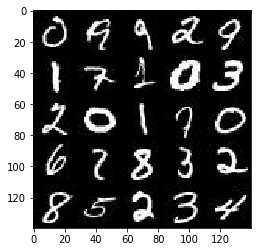

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

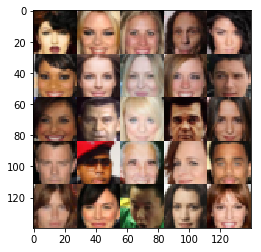

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 for MNIST or 28x28x3 for CelebA
        # No batch normalization on first layer
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now <- (28 - 4 + 2)/2 + 1 = 14
        #print('discriminator x1 shape ', x1.shape)
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now <- (14 - 4 + 2)/2 + 1 = 7
        #print('discriminator x2 shape ', x2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256 now <- (7 - 5 + 2)/2 + 1 = 3
        #print('discriminator x3 shape ', x3.shape)

        # Flatten it
        #flat = tf.reshape(relu2, (-1, 7*7*128)) before adding additional layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    # print(out_channel_dim) <- value of 5 in unit test
    #output_dim = (28, 28, out_channel_dim)
    
    with tf.variable_scope('generator', reuse=not is_train): # <- not sure if reuse during training
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape) # <- (6000, 28, 28, 1) for MNIST training
    #print(data_image_mode) # <- "L" for MNIST training
    
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # print(batch_images.shape) # <- (128, 28, 28, 1) for MNIST
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5
                #  of 28x28 dimensional images.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    # def generator(z, out_channel_dim, is_train=True)
                    #gen_samples = sess.run(
                    #               generator(input_z, out_channel_dim, is_train=False),
                    #               feed_dict={input_z: sample_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()
                    
        # show images at end of training
        #show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.0975 ... Generator Loss: 9.5165
Epoch 1/2... Discriminator Loss: 3.7482 ... Generator Loss: 0.1661
Epoch 1/2... Discriminator Loss: 0.2533 ... Generator Loss: 2.1372
Epoch 1/2... Discriminator Loss: 1.4964 ... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.3831 ... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.7655 ... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 1.5364 ... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 2.0829 ... Generator Loss: 0.1733
Epoch 1/2... Discriminator Loss: 1.3149 ... Generator Loss: 0.3975
Epoch 1/2... Discriminator Loss: 1.7930 ... Generator Loss: 0.2584


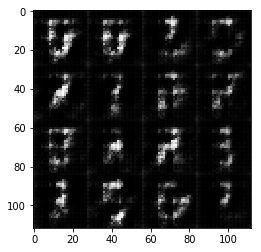

Epoch 1/2... Discriminator Loss: 1.7311 ... Generator Loss: 0.3659
Epoch 1/2... Discriminator Loss: 1.5790 ... Generator Loss: 0.3360
Epoch 1/2... Discriminator Loss: 1.5336 ... Generator Loss: 0.3734
Epoch 1/2... Discriminator Loss: 1.5642 ... Generator Loss: 0.3772
Epoch 1/2... Discriminator Loss: 1.4638 ... Generator Loss: 0.3614
Epoch 1/2... Discriminator Loss: 1.7009 ... Generator Loss: 0.2955
Epoch 1/2... Discriminator Loss: 1.6817 ... Generator Loss: 0.2990
Epoch 1/2... Discriminator Loss: 1.5590 ... Generator Loss: 0.3344
Epoch 1/2... Discriminator Loss: 1.6076 ... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 1.5666 ... Generator Loss: 0.3415


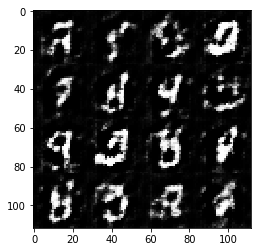

Epoch 1/2... Discriminator Loss: 1.5488 ... Generator Loss: 0.4076
Epoch 1/2... Discriminator Loss: 1.5041 ... Generator Loss: 0.3428
Epoch 1/2... Discriminator Loss: 1.4873 ... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.7275 ... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.4513 ... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 1.5796 ... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 1.5350 ... Generator Loss: 0.3272
Epoch 1/2... Discriminator Loss: 1.5492 ... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 1.2300 ... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.8978 ... Generator Loss: 0.2226


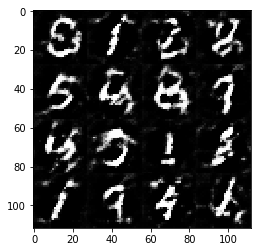

Epoch 1/2... Discriminator Loss: 1.2788 ... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.4833 ... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.6511 ... Generator Loss: 0.3178
Epoch 1/2... Discriminator Loss: 1.2179 ... Generator Loss: 0.4983
Epoch 1/2... Discriminator Loss: 1.3627 ... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 1.5600 ... Generator Loss: 0.3565
Epoch 1/2... Discriminator Loss: 1.3658 ... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 1.5377 ... Generator Loss: 0.3350
Epoch 1/2... Discriminator Loss: 1.4538 ... Generator Loss: 0.3947
Epoch 1/2... Discriminator Loss: 1.6437 ... Generator Loss: 0.3350


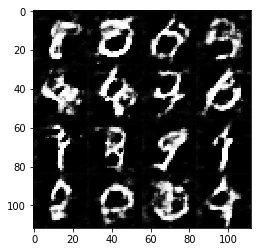

Epoch 1/2... Discriminator Loss: 1.4958 ... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 1.4900 ... Generator Loss: 0.4461
Epoch 1/2... Discriminator Loss: 0.7773 ... Generator Loss: 1.4964
Epoch 1/2... Discriminator Loss: 1.4355 ... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 1.4211 ... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 1.5413 ... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 1.3807 ... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.2277 ... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.3602 ... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 1.4135 ... Generator Loss: 1.6577


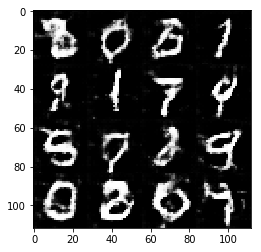

Epoch 2/2... Discriminator Loss: 1.3750 ... Generator Loss: 1.1426
Epoch 2/2... Discriminator Loss: 1.2741 ... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 1.4919 ... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 1.2642 ... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.4762 ... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.4477 ... Generator Loss: 1.4576
Epoch 2/2... Discriminator Loss: 1.3289 ... Generator Loss: 1.5661
Epoch 2/2... Discriminator Loss: 1.4729 ... Generator Loss: 1.4271
Epoch 2/2... Discriminator Loss: 1.2057 ... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 1.7396 ... Generator Loss: 0.2487


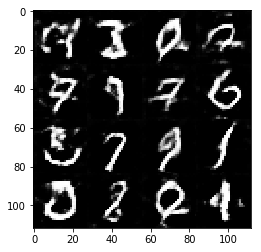

Epoch 2/2... Discriminator Loss: 1.3989 ... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 1.5374 ... Generator Loss: 0.3564
Epoch 2/2... Discriminator Loss: 1.4437 ... Generator Loss: 0.3754
Epoch 2/2... Discriminator Loss: 1.3858 ... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.5008 ... Generator Loss: 0.3666
Epoch 2/2... Discriminator Loss: 1.4090 ... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 1.4854 ... Generator Loss: 0.3745
Epoch 2/2... Discriminator Loss: 1.3814 ... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.5999 ... Generator Loss: 0.3281
Epoch 2/2... Discriminator Loss: 1.3277 ... Generator Loss: 0.4723


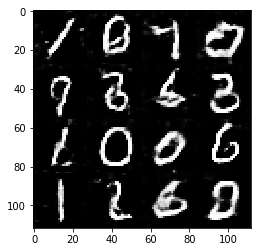

Epoch 2/2... Discriminator Loss: 1.4905 ... Generator Loss: 0.3620
Epoch 2/2... Discriminator Loss: 1.4398 ... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.1011 ... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.6298 ... Generator Loss: 0.2682
Epoch 2/2... Discriminator Loss: 1.3940 ... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 1.4209 ... Generator Loss: 0.3968
Epoch 2/2... Discriminator Loss: 1.5114 ... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 1.4429 ... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.3214 ... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.4664 ... Generator Loss: 0.3788


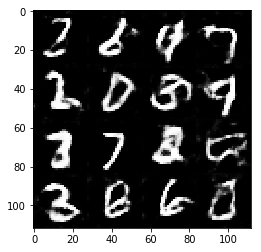

Epoch 2/2... Discriminator Loss: 1.3845 ... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 1.5146 ... Generator Loss: 0.3878
Epoch 2/2... Discriminator Loss: 1.2834 ... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 1.4328 ... Generator Loss: 0.4348
Epoch 2/2... Discriminator Loss: 1.4882 ... Generator Loss: 0.3545
Epoch 2/2... Discriminator Loss: 1.2829 ... Generator Loss: 0.4808
Epoch 2/2... Discriminator Loss: 1.4602 ... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.2694 ... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 1.3339 ... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.5326 ... Generator Loss: 0.4126


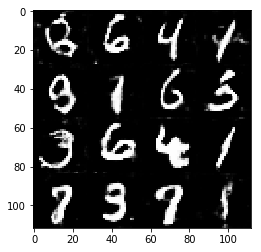

Epoch 2/2... Discriminator Loss: 1.2874 ... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.2248 ... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.6035 ... Generator Loss: 0.2946


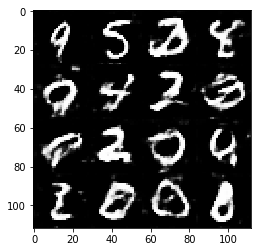

In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.001

# https://discussions.udacity.com/t/project-facegeneration-indexerror-list-index-out-of-range/246401
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3369 ... Generator Loss: 4.4708
Epoch 1/1... Discriminator Loss: 1.1788 ... Generator Loss: 8.6488
Epoch 1/1... Discriminator Loss: 0.6569 ... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 0.8641 ... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 0.2310 ... Generator Loss: 4.3771
Epoch 1/1... Discriminator Loss: 1.4759 ... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.2514 ... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 0.5114 ... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.1693 ... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 0.6955 ... Generator Loss: 0.9116


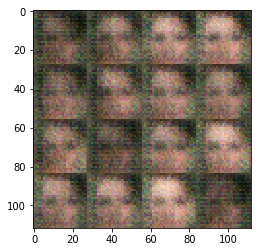

Epoch 1/1... Discriminator Loss: 1.0278 ... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.7715 ... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2939 ... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 0.8056 ... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3306 ... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 0.8889 ... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3556 ... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.1144 ... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.9987 ... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.0637 ... Generator Loss: 0.5887


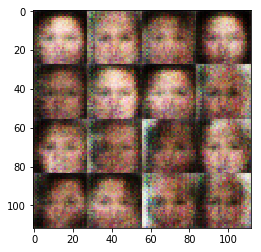

Epoch 1/1... Discriminator Loss: 1.4238 ... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 0.9715 ... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2852 ... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.0914 ... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.0667 ... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 0.9417 ... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.0910 ... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 0.8846 ... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.0909 ... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 0.9549 ... Generator Loss: 0.6888


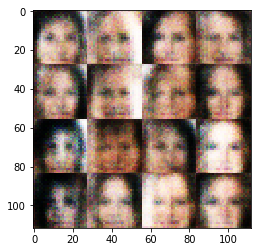

Epoch 1/1... Discriminator Loss: 0.8305 ... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.7552 ... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.1277 ... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.0588 ... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.3546 ... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 0.9657 ... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.2998 ... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 0.7307 ... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 0.7113 ... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 1.1452 ... Generator Loss: 0.5016


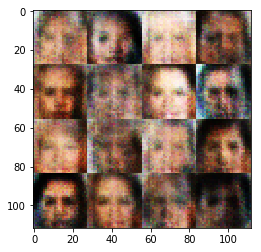

Epoch 1/1... Discriminator Loss: 1.1249 ... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.0528 ... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.0606 ... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 0.9778 ... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4226 ... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.0028 ... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.0642 ... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.0718 ... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.2488 ... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2169 ... Generator Loss: 0.4858


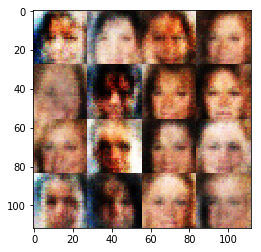

Epoch 1/1... Discriminator Loss: 1.0304 ... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.2760 ... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.0355 ... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.2168 ... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.1116 ... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.0673 ... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1182 ... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.3978 ... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.1155 ... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.2451 ... Generator Loss: 0.4700


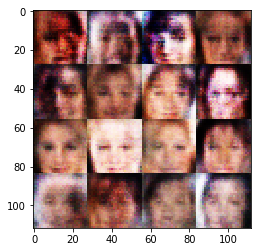

Epoch 1/1... Discriminator Loss: 1.2655 ... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.2450 ... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.2516 ... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.1672 ... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.2077 ... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.1874 ... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.3321 ... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.1295 ... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.3035 ... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.1705 ... Generator Loss: 0.5030


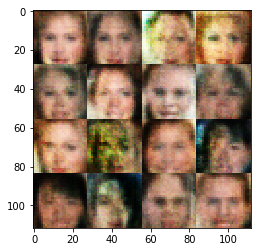

Epoch 1/1... Discriminator Loss: 0.8513 ... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3576 ... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.1058 ... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.2423 ... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.3129 ... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 0.9804 ... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2671 ... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.2512 ... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.0102 ... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.1165 ... Generator Loss: 0.5233


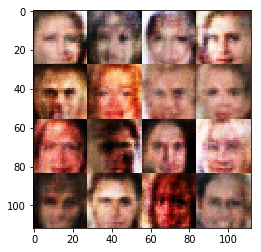

Epoch 1/1... Discriminator Loss: 1.3977 ... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 0.9758 ... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1968 ... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.0965 ... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.0691 ... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.3209 ... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 0.8207 ... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.4434 ... Generator Loss: 1.8279
Epoch 1/1... Discriminator Loss: 0.7225 ... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 1.1444 ... Generator Loss: 1.9982


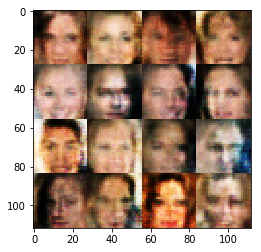

Epoch 1/1... Discriminator Loss: 1.0981 ... Generator Loss: 2.2860
Epoch 1/1... Discriminator Loss: 1.1495 ... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.9471 ... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 0.7884 ... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 1.7429 ... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 0.7698 ... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 0.7558 ... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.6452 ... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.2998 ... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.1828 ... Generator Loss: 0.4875


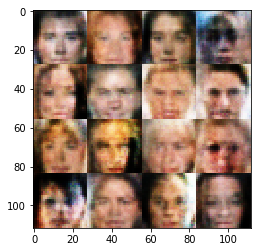

Epoch 1/1... Discriminator Loss: 0.6978 ... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 1.1276 ... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.8787 ... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 1.4810 ... Generator Loss: 1.9326
Epoch 1/1... Discriminator Loss: 0.8036 ... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.8855 ... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3544 ... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 1.5720 ... Generator Loss: 0.2811
Epoch 1/1... Discriminator Loss: 0.9384 ... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 0.6618 ... Generator Loss: 1.0936


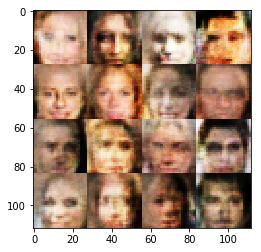

Epoch 1/1... Discriminator Loss: 0.8816 ... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2985 ... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.0938 ... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2676 ... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.7255 ... Generator Loss: 0.2448
Epoch 1/1... Discriminator Loss: 1.0284 ... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1010 ... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.0534 ... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.0169 ... Generator Loss: 2.2524
Epoch 1/1... Discriminator Loss: 2.1291 ... Generator Loss: 2.6749


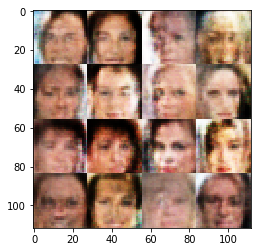

Epoch 1/1... Discriminator Loss: 0.6989 ... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.4974 ... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 0.8869 ... Generator Loss: 2.7519
Epoch 1/1... Discriminator Loss: 1.0013 ... Generator Loss: 1.8544
Epoch 1/1... Discriminator Loss: 0.9174 ... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 0.6147 ... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.5064 ... Generator Loss: 2.3064
Epoch 1/1... Discriminator Loss: 1.0644 ... Generator Loss: 2.4380
Epoch 1/1... Discriminator Loss: 1.1171 ... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 0.7060 ... Generator Loss: 1.0174


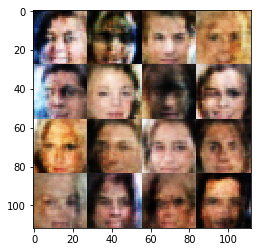

Epoch 1/1... Discriminator Loss: 1.2562 ... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.6321 ... Generator Loss: 0.2638
Epoch 1/1... Discriminator Loss: 0.8322 ... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.0524 ... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.2754 ... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.3185 ... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.5712 ... Generator Loss: 0.2938
Epoch 1/1... Discriminator Loss: 0.6339 ... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.5591 ... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.8041 ... Generator Loss: 2.9077


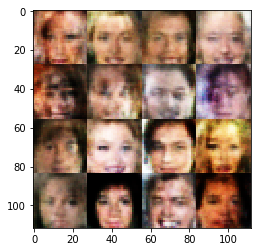

Epoch 1/1... Discriminator Loss: 0.9968 ... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.5347 ... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.4841 ... Generator Loss: 2.5466
Epoch 1/1... Discriminator Loss: 0.9413 ... Generator Loss: 2.4658
Epoch 1/1... Discriminator Loss: 0.9606 ... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 0.7816 ... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.7813 ... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.6661 ... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.0071 ... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.8716 ... Generator Loss: 0.2092


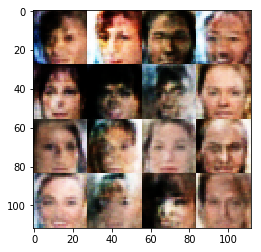

Epoch 1/1... Discriminator Loss: 0.6167 ... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.7084 ... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.8683 ... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4295 ... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.2878 ... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.6264 ... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 1.0243 ... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.0876 ... Generator Loss: 0.5055


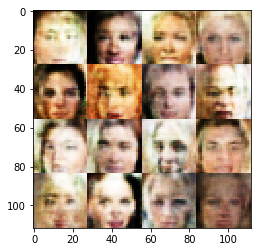

In [34]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.0001


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.